In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import json

from Modules.Feature_Extraction_temporal_domain import *

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Read Preprocessed Data

In [3]:
def read_csv(filepath):
    f = open(filepath)
    data = json.load(f)
    return data

ecg = read_csv('Preprocessed_data/ecg/ecg_unfiltered.txt')
ecg_filt = read_csv('Preprocessed_data/ecg/ecg_filtered.txt')

### Crop segments of the signals to remove a few minutes from the start and end
At the very beginning or the end, the device is being attached? removed from the patient hence leading to a high variance in signals

In [4]:
#remove first and last few minutes
for patient in ecg_filt:
    ecg_filt[patient] = ecg_filt[patient][5000:700000]
    ecg[patient] = ecg[patient][5000:700000]

### Divide signals from patients into chunks of 10 seconds

In [5]:
duration = int(15*62.475)
segments_ecg = {}

for patient in ecg:
    values = ecg[patient]
    segments_ecg[patient] = []
    for i in range(0,len(values) - duration + 1, duration):
        segments_ecg[patient].append(values[i : (i + duration)])

## Feature extraction from the temporal domain
Morphological/time domain features are commonly used to train the machine learning models. We will extract some of the common ECG features in the literature. Some features can be calculated using only R-peak locations while others requires information on the other fiducial points (P, Q, S and T waves).

#### Features from R peaks

The ___from_Rpeaks___ function calculates morphological features using R-peak locations. These features are:

'RR1': Current RR interval
'RRm': Mean of RR0, RR1 and RR2

#### Features from P, Q, R, S, T waves

The ___from_waves___ function calculates morphological features using locations of P, Q, R, S, T waves. These features are:

't_PR': Time between P and R peak locations
't_QS': Time between Q and S peak locations
't_QT':Time between Q and T peak locations
't_PT_QS': Ratio of t_PT to t_QS
't_QT_QS': Ratio of t_QT to t_QS

In [ ]:
sampling_rate = 62.475

patient_id = [" "]* len(segments_ecg)
all_filtered_signals = [[]]*len(segments_ecg)
unfiltered_signals = [[]]*len(segments_ecg)
all_locs_peaks = [[]]*len(segments_ecg)
all_p_peaks_locs = [[]]*len(segments_ecg)
all_q_peaks_locs = [[]]*len(segments_ecg)
all_features_rpeaks = [[]]*len(segments_ecg)
all_features_waves = [[]]*len(segments_ecg)

for i in range(len(list(segments_ecg.keys()))):
    patient  = list(segments_ecg.keys())[i]
    patient_id[i] = patient
    for j in range(len(segments_ecg[patient])):
        try:
            filtered_ecg, locs_peaks, p_peaks_locs, q_peaks_locs, features_rpeaks, features_waves = find_features(segments_ecg[patient][j], sampling_rate)
            unfiltered_signals[i].append(segments_ecg[patient][j])
            all_filtered_signals[i].append(filtered_ecg)
            all_locs_peaks[i].append(locs_peaks)
            all_p_peaks_locs[i].append(p_peaks_locs)
            all_q_peaks_locs[i].append(q_peaks_locs)
            all_features_rpeaks[i].append(features_rpeaks)
            all_features_waves[i].append(features_waves)
        except:
            continue

In [7]:
patient_num = 1
sample_num = 3

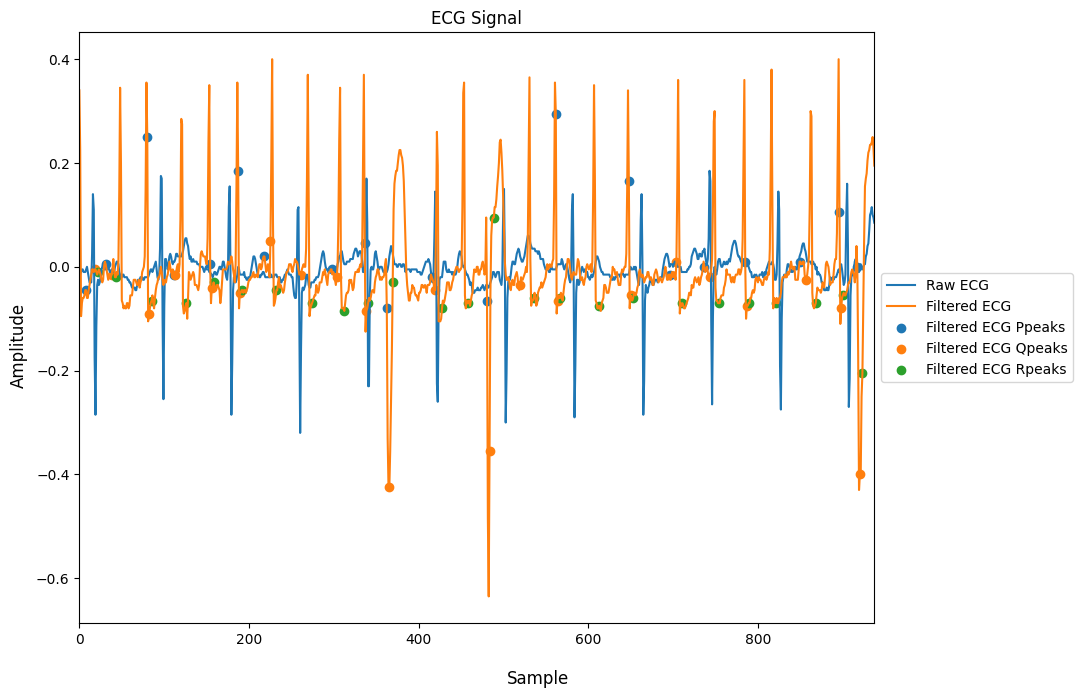

In [8]:
#Generate inputs as dictionaries. The peaks are plotted for raw signal and skipped for filtered signal.

signals={'Raw':unfiltered_signals[patient_num][sample_num] , 'Filtered': all_filtered_signals[patient_num][sample_num]}
peaks={'Filtered': {'Ppeaks':all_p_peaks_locs[patient_num][sample_num], 'Qpeaks': all_q_peaks_locs[patient_num][sample_num], 'Rpeaks': all_locs_peaks[patient_num][sample_num]}}

#Plot ECG signals
plot_ecg(signals=signals, peaks=peaks, show_peaks=True, figsize=(11, 7))

In [9]:
len(all_features_waves[patient_num])

11884

### Extracting relevant features into a dataframe

In [10]:
features_waves_df = pd.DataFrame(all_features_waves[patient_num])
features_waves_df  = features_waves_df.fillna(0)
features_waves_reduced = features_waves_df[["ecg_t_PR", "ecg_t_QS", "ecg_t_QT", "ecg_t_PT_QS", "ecg_t_QT_QS"]]

features_rpeaks_df = pd.DataFrame(all_features_rpeaks[patient_num])
features_rpeaks_df  = features_rpeaks_df.fillna(0)
features_repaks_reduced = features_rpeaks_df[["ecg_RR1", "ecg_RRm"]]

features_waves_reduced["ecg_RR1"] = features_rpeaks_df[["ecg_RR1"]]
features_waves_reduced["ecg_RRm"] = features_rpeaks_df[["ecg_RRm"]]

### Clustering using DBSCAN
DBSCAN requires only two parameters: epsilon and minPoints. Epsilon is the radius of the circle to be created around each data point to check the density and minPoints is the minimum number of data points required inside that circle for that data point to be classified as a Core point.

In [15]:
clustering = DBSCAN(eps=1, min_samples=100).fit(features_waves_reduced)
DBSCAN_dataset = features_waves_reduced.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_

DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
0,9986
2,1390
1,481
-1,27


In [16]:
y_pred = clustering.fit_predict(features_waves_reduced)

anomoly_indices = np.where(y_pred == -1)[0]

anomolous_signals = np.take(features_waves_reduced, anomoly_indices, 0)
anomolous_signals

,ecg_t_PR,ecg_t_QS,ecg_t_QT,ecg_t_PT_QS,ecg_t_QT_QS,ecg_RR1,ecg_RRm
1209,0.135439,0.100963,0.429710,5.896398,5.043590,1.232493,1.194611
1659,0.000000,0.138237,0.579141,0.000000,4.318953,1.418567,1.459917
5864,0.422569,0.307323,0.733093,4.933294,3.451939,0.392157,2.302254
6335,0.190076,0.188075,0.372149,3.589656,2.524565,2.602641,2.574897
7152,0.308123,0.328131,0.606242,2.981599,2.483708,2.260104,2.311325
7157,0.000000,0.549553,0.786981,0.000000,1.496569,1.851407,1.902983
7166,0.000000,0.000000,0.000000,0.000000,0.000000,2.849140,2.673069
7197,0.000000,0.000000,0.000000,0.000000,0.000000,2.953181,2.499667
7203,0.000000,0.660264,0.000000,0.000000,0.000000,1.216487,4.279045
7204,0.364146,0.516206,1.044418,2.733643,2.119947,3.073229,4.407096


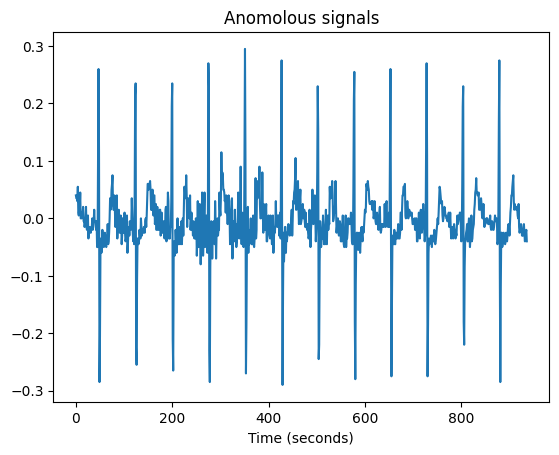

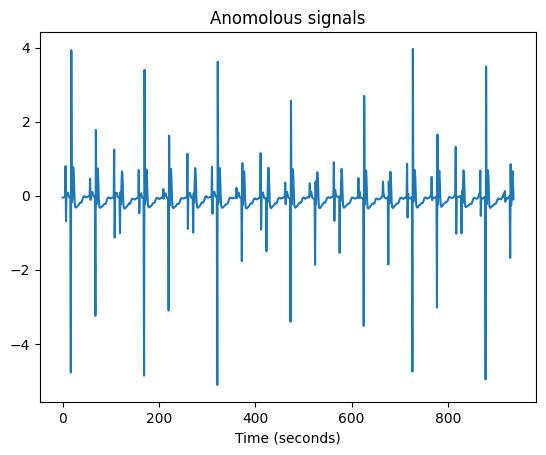

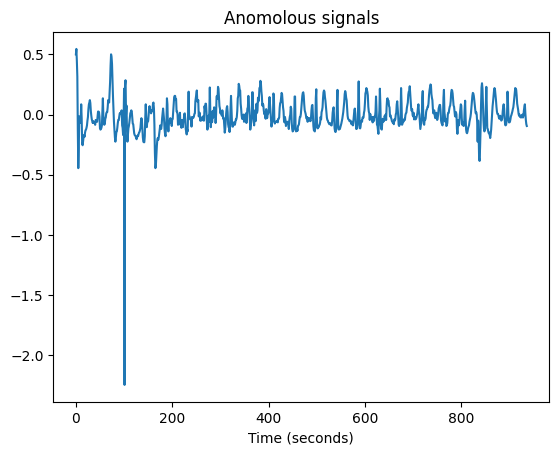

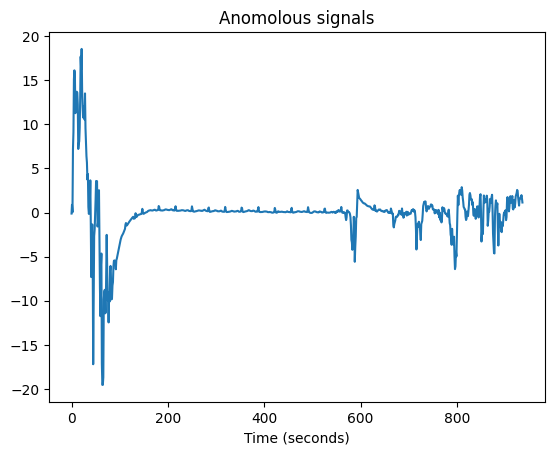

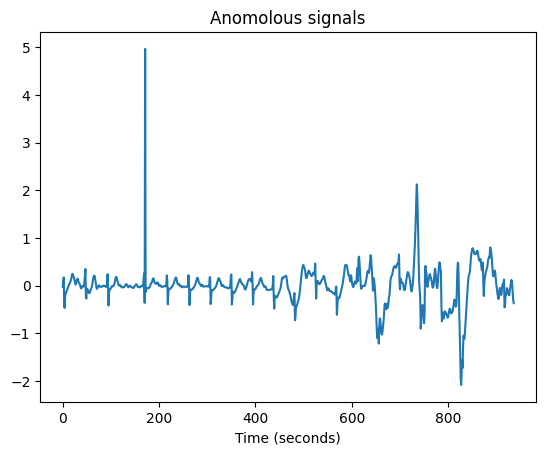

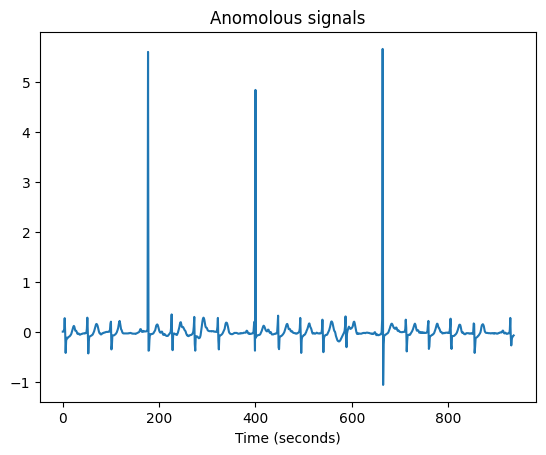

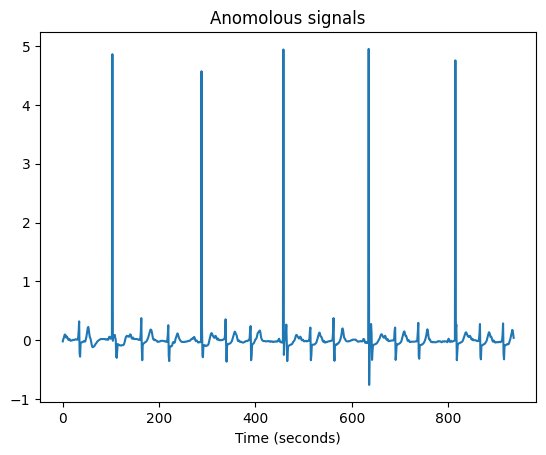

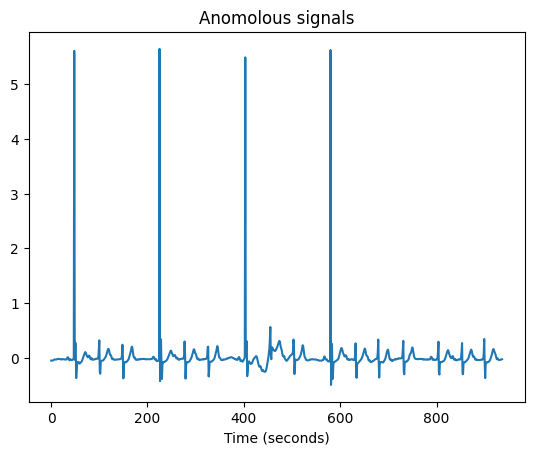

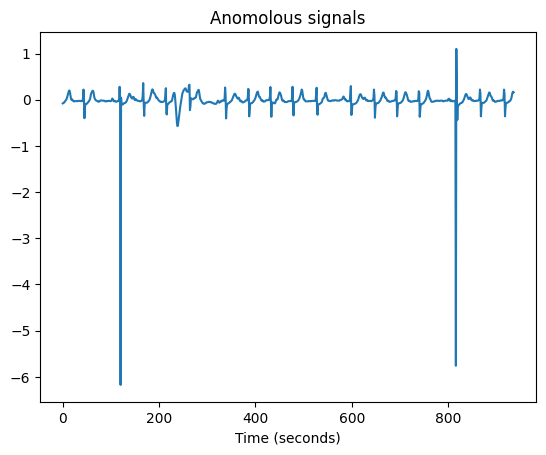

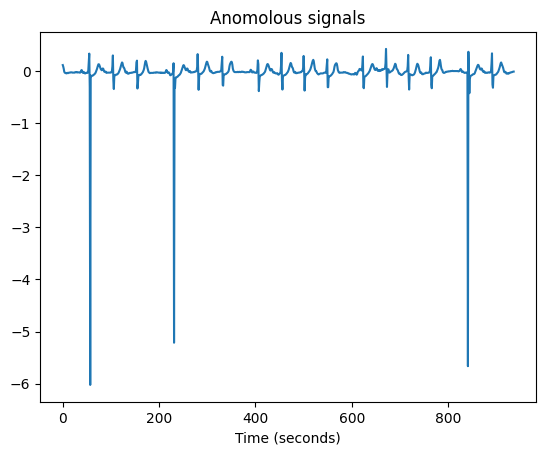

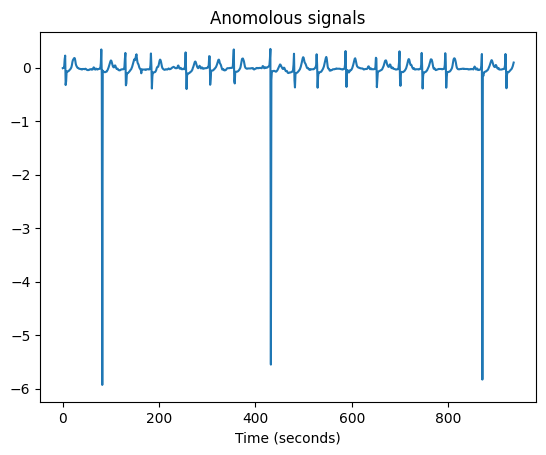

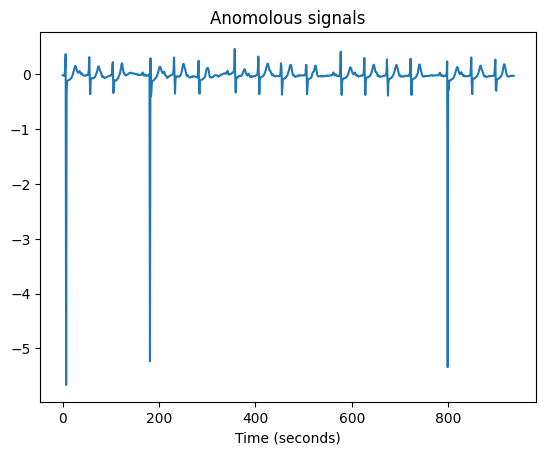

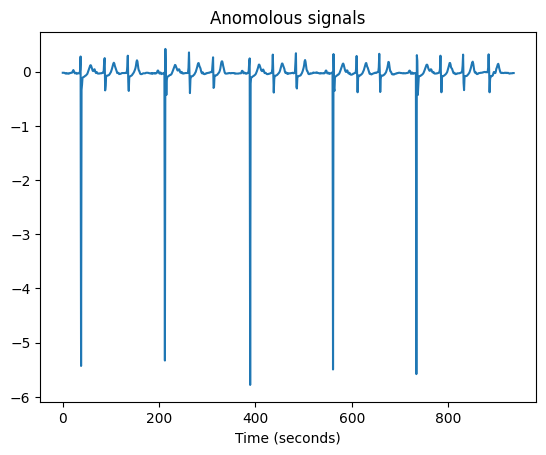

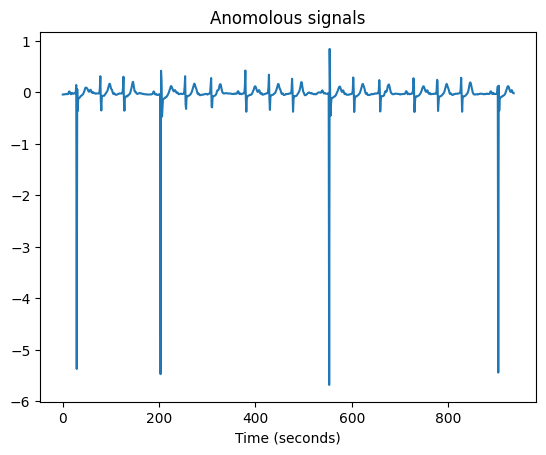

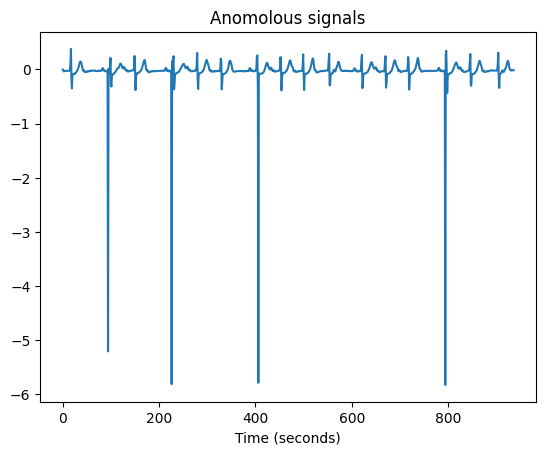

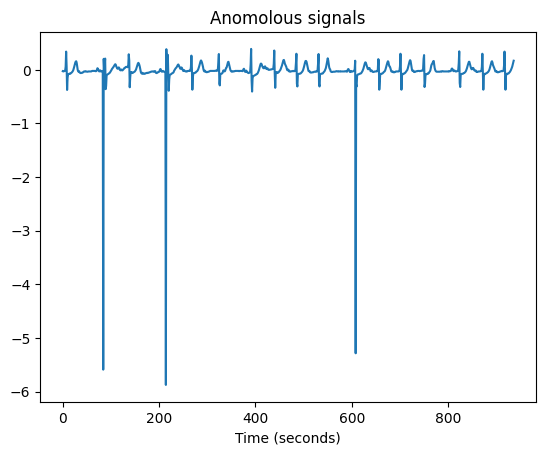

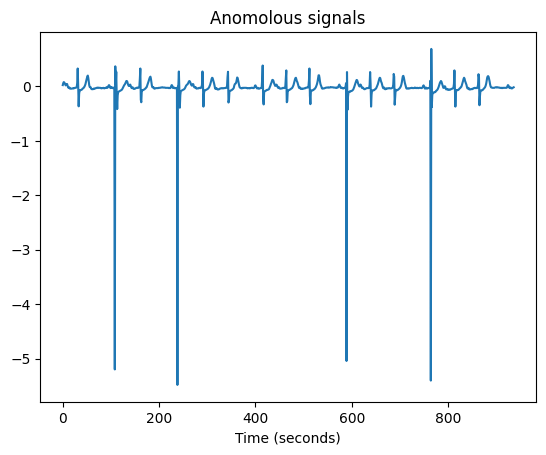

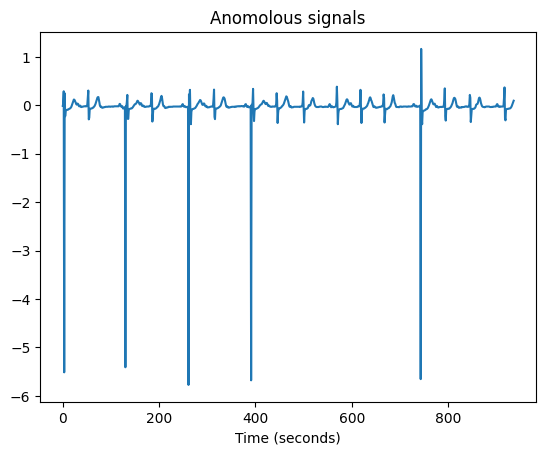

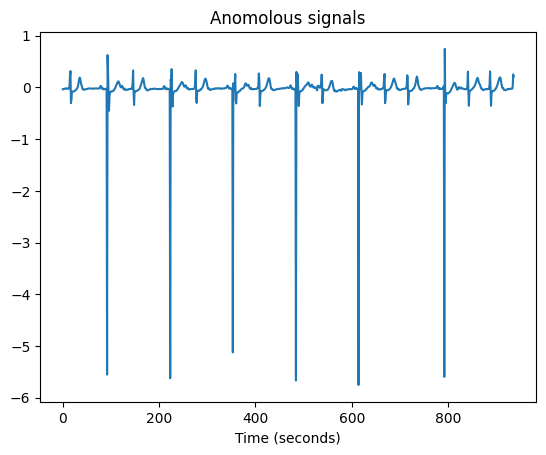

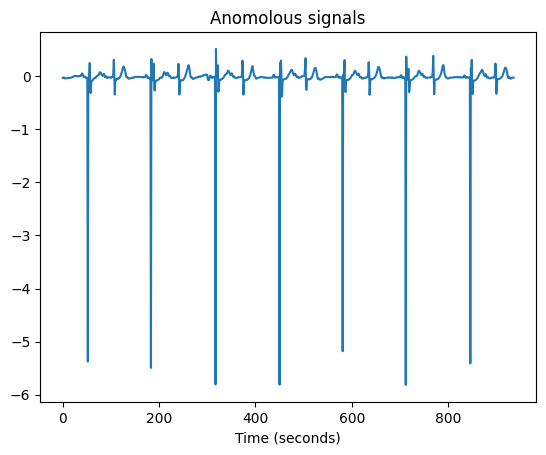

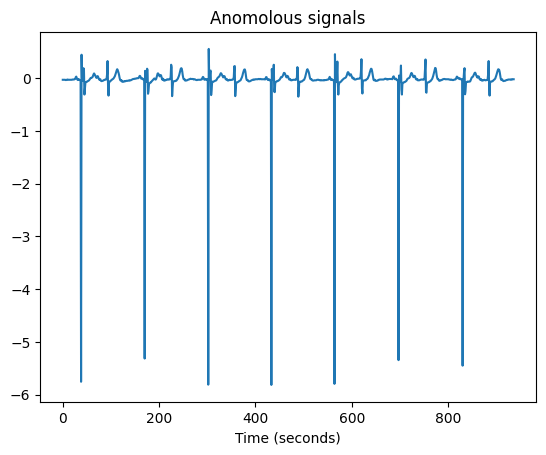

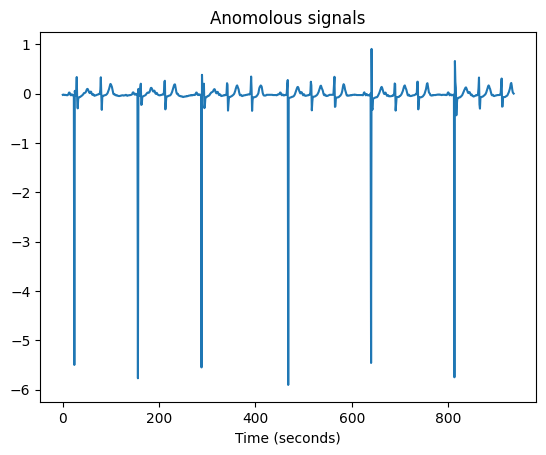

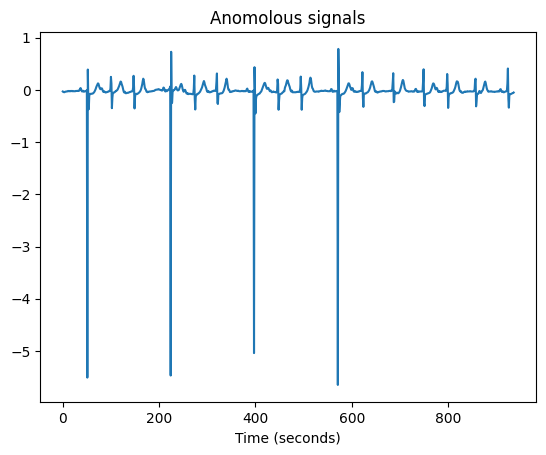

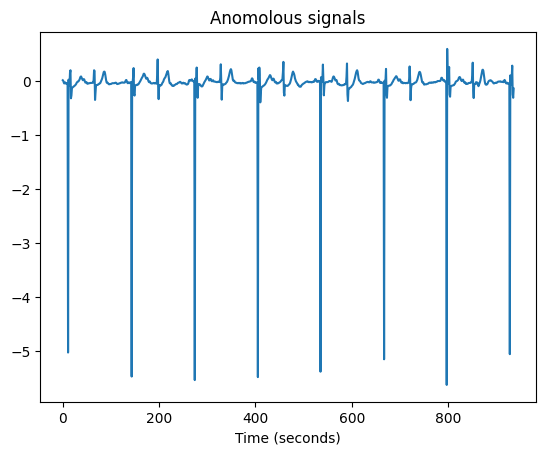

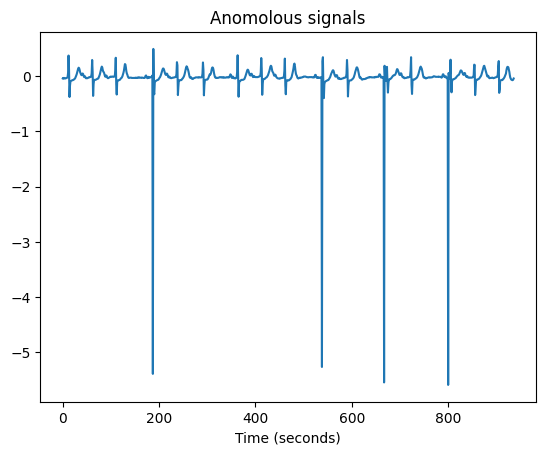

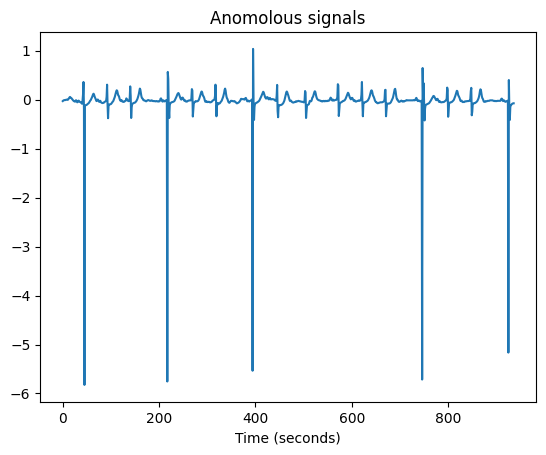

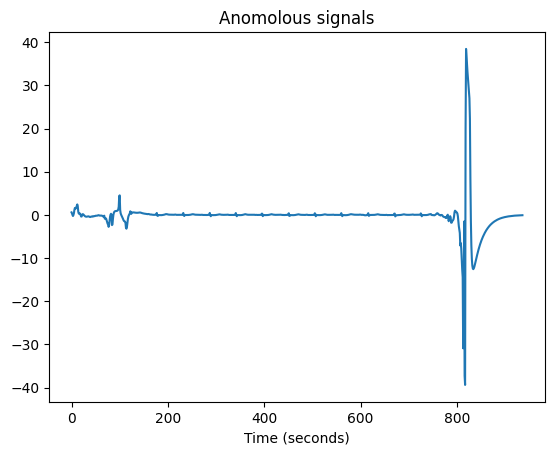

In [18]:
# Prepare figure

for i in range(len(anomoly_indices)):
    fig, ax = plt.subplots()

    ax.set_title("Anomolous signals")
    ax.set_xlabel("Time (seconds)")

    ax.plot(all_filtered_signals[patient_num][anomoly_indices[i]])


### Physiological Limits of Anomolous signals:
The phsyiological limits can be compared to the accepted values in the literature. Reference: https://link.springer.com/book/10.1007/978-3-319-68415-4

These values are defined as constants in the corresponding modules as given below.

Physiological limits:

HR_MIN = 40 #minimum heart rate
HR_MAX = 180 #maximum heart rate
PP_MAX = 3 #maximum peak to peak interval

In [13]:
#Peak detection

for i in range(len(anomoly_indices)):
    locs_peaks=ecg_detectpeaks(all_filtered_signals[anomoly_indices[i]],sampling_rate,'pantompkins')
    peaks = [all_filtered_signals[anomoly_indices[i]][j] for j in locs_peaks]

    #Check for physiological limits
    info=check_phys(locs_peaks,sampling_rate)
    print("Anomolous Signal "+ str(i))
    print(info)

Anomolous Signal 0
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}
Anomolous Signal 1
{'Rule 1': True, 'Rule 2': False, 'Rule 3': False}
Anomolous Signal 2
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}
Anomolous Signal 3
{'Rule 1': False, 'Rule 2': False, 'Rule 3': False}
Anomolous Signal 4
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}
Anomolous Signal 5
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}
Anomolous Signal 6
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}
Anomolous Signal 7
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}
Anomolous Signal 8
{'Rule 1': True, 'Rule 2': True, 'Rule 3': True}
Anomolous Signal 9
{'Rule 1': True, 'Rule 2': True, 'Rule 3': True}


#### Template Matching

A common method for signal quality assessment is "Template Matching". This method is based on the expectation that pulse waveforms in an ECG segment will have similar morphology. A template is generated by aligning the pulses by their R-peaks and averaging them. Then, similarity of each pulse with the template is calculated using a measure. The ___template_matching___ function uses Pearson correlation as similarity measure. The function returns a tuple of correlation coefficients and a boolean result for the quality of the segment.

In [14]:
#Template matching
for i in range(len(anomoly_indices)):
    locs_peaks=ecg_detectpeaks(all_filtered_signals[anomoly_indices[i]],sampling_rate,'pantompkins')
    info=template_matching(all_filtered_signals[anomoly_indices[i]],locs_peaks)
    print("Anomolous Signal "+ str(i))
    print(info[1])


Anomolous Signal 0
False
Anomolous Signal 1
False
Anomolous Signal 2
False
Anomolous Signal 3
False
Anomolous Signal 4
False
Anomolous Signal 5
False
Anomolous Signal 6
False
Anomolous Signal 7
False
Anomolous Signal 8
False
Anomolous Signal 9
False
